In [35]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf

In [3]:
from math import floor
from lib_augment import load_and_normalize
from lib_feature import feature_whistleness

%matplotlib inline
import matplotlib.pyplot as plt


In [31]:
# deploy_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/STAR2000_48kHz'
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
fs = 48000
time_reso = 0.02
hop_length = int(time_reso*fs)  #
species_list = list(species_dict.keys())
species_id = list(species_dict.values())
num_species = len(species_dict)

In [5]:
species_to_code = {'bottlenose': 'BD', 'longbeaked_common': 'CD', 'shortbeaked_common': 'CD', 'common': 'CD',
                   'striped': 'STR', 'spotted': 'SPT', 'spinner': 'SPIN', 'pilot': 'PLT', 'roughtoothed': 'RT',
                   'false_killer': 'FKW'}

In [6]:
step_sec = 1.0  # sec
whistle_ratio = 0.2  # percentage of whislteness frames in a long window
# step_size = int(1.0*fs)
win_long_sec = 10   # 10 sec
step_ind = int(win_long_sec/step_sec)
step_size = int(step_sec*fs)
win_size = int(2.0*fs)

In [7]:
ten_sec_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/ten_seconds_data'

In [67]:
# Hyper parameters
learning_rate = 1.0e-3
drop_rate = 0.2
hidden_units = 256
fcn_dim = 256

num_epoch = 200
# batch_size = 128
# batch_size = 32  # for cnn14+attention
batch_size = 16  # for cnn14+spp

num_patience = 5

In [11]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [62]:
from datetime import datetime
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

In [63]:
ee = 'STAR2000'
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    os.makedirs(fit_result_path2)

## Load features

In [8]:
# np.savez(os.path.join(ten_sec_path, sound_deploy[dd]), feature_train=feature_train, label_train=label_train, feature_test=feature_test, label_test=label_test)
feature_curr = np.load(os.path.join(ten_sec_path, 'STAR2000_48kHz_test_others_train_embedding.npz'))
embedding_train = feature_curr['embedding_train']
embedding_test = feature_curr['embedding_test']
label_train = feature_curr['label_train']
label_test = feature_curr['label_test']
del feature_curr

In [15]:
label_train_list = list(label_train)
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [16]:
label_test_list = list(label_test)
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [20]:
from collections import Counter
print(Counter(label_train_list))
print(Counter(label_test_list))

Counter({'FKW': 10266, 'PLT': 7334, 'BD': 5976, 'STR': 5790, 'SPT': 5314, 'RT': 4081, 'SPIN': 2091, 'CD': 1725})
Counter({'CD': 836, 'STR': 346, 'SPT': 176, 'SPIN': 108, 'BD': 41, 'RT': 22, 'PLT': 13})


In [ ]:
Counter(label_test.tolist())

In [14]:
dim_time = embedding_train.shape[1]
dim_freq = embedding_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

dim_time: 10
dim_freq: 256


In [37]:
## Model

In [38]:
# Kong's attention
# def max_pooling(inputs, **kwargs):
#     input = inputs[0]   # (batch_size, time_steps, freq_bins)
#     return K.max(input, axis=1)
def max_pooling(inputs, **kwargs):
    # input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.max(inputs, axis=1)


def average_pooling(inputs, **kwargs):
    input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.mean(input, axis=1)


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)


def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

In [25]:
# cnn14 attention with customized maxpooling
def model_cnn0_attention_multi(time_steps, freq_bins, classes_num, model_type='feature_level_attention', hidden_units=512, 
                               drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins), name='input')

    a2 = Dense(hidden_units)(input_layer)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [42]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

# shuffle features & labels
embedding_train, label_train = shuffle(embedding_train, label_train, random_state=0)
embedding_test, label_test = shuffle(embedding_test, label_test, random_state=0)

In [32]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [44]:
embedding_train, embedding_validate, label_train, label_validate = train_test_split(embedding_train, label_train, test_size=0.10, random_state=42+4)

train_generator = DataGenerator(embedding_train, label_train, batch_size=batch_size, num_classes=num_species)
del embedding_train
validate_generator = DataGenerator(embedding_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del embedding_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


In [64]:
model = model_cnn0_attention_multi(dim_time, dim_freq, num_species, model_type='decision_level_multi_attention',hidden_units=hidden_units, drop_rate=drop_rate)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10, 256)]    0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 10, 256)      65792       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 10, 256)      1024        dense_15[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 10, 256)      0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [65]:
loss = binary_crossentropy
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])

In [66]:
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

Epoch 1/200
2154/2155 [============================>.] - ETA: 0s - loss: 0.1563 - accuracy: 0.9001
Epoch 00001: val_accuracy improved from -inf to 0.94770, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210325_113130/STAR2000/epoch_01_valloss_0.0676_valacc_0.9477.hdf5
2155/2155 [==============================] - 18s 8ms/step - loss: 0.1563 - accuracy: 0.9001 - val_loss: 0.0676 - val_accuracy: 0.9477
Epoch 2/200
2150/2155 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9487
Epoch 00002: val_accuracy improved from 0.94770 to 0.96731, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210325_113130/STAR2000/epoch_02_valloss_0.0339_valacc_0.9673.hdf5
2155/2155 [==============================] - 18s 8ms/step - loss: 0.0562 - accuracy: 0.9488 - val_loss: 0.0339 - val_accuracy: 0.9673
Epoch 3/200
2150/2155 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.9640
Epoch 00

KeyboardInterrupt: 

In [46]:
# def find_best_model(model_folder, remove_others=False):
#     model_list = glob.glob(model_folder+'/*.hdf5')
#     model_list.sort()
#     the_best_model = model_list[-1]
    
#     if remove_others==True:
#         for mm in model_list[:-1]:
#             os.remove(mm)
            
#     print(the_best_model)
    
#     return the_best_model
import re

def find_best_model(classifier_path, fmt='epoch_\d+_valloss_(\d+.\d{4})_valacc_(\d+.\d{4}).hdf5', is_max=True, purge=True):
    """
    Return the path to the model with the best accuracy, given the path to
    all the trained classifiers
    Args:
        classifier_path: path to all the trained classifiers
        fmt: e.g. "epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5"
        'epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5'
        is_max: use max; otherwise, min
        purge: True to purge models files except the best one
    Return:
        the path of the model with the best accuracy
    """
    # list all files ending with .hdf5
    day_list = sorted(glob.glob(os.path.join(classifier_path + '/', '*.hdf5')))

    # re the last 4 digits for accuracy
    hdf5_filename = []
    hdf5_accu = np.zeros(len(day_list))
    for dd in range(len(day_list)):
        filename = os.path.basename(day_list[dd])
        hdf5_filename.append(filename)
        # m = re.search("_F1_(0.\d{4}).hdf5", filename)
        # m = re.search("_([0-1].\d{4}).hdf5", filename)
        # m = re.search("epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5", filename)
        m = re.search(fmt, filename)
        try:
            #  hdf5_accu[dd] = float(m.groups()[0])
            hdf5_accu[dd] = float(m.groups()[1])
        except:
            continue

    # select the laregest one and write to the variable classifier_file
    if len(hdf5_accu) == 0:
        best_model_path = ''
        best_accu = 0
    else:
        if is_max is True:
            ind_max = np.argmax(hdf5_accu)
        else: # use min instead
            ind_max = np.argmin(hdf5_accu)
        best_model_path = day_list[int(ind_max)]
        best_accu = hdf5_accu[ind_max]
        # purge all model files except the best_model
        if purge:
            for ff in day_list:
                if ff != best_model_path:
                    os.remove(ff)
    print('Best model:'+str(best_accu))
    print(best_model_path)
    return best_model_path, best_accu


In [68]:
# fit_result_path2 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210310_095616/STAR2000'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.9987
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210325_113130/STAR2000/epoch_29_valloss_0.0018_valacc_0.9987.hdf5


In [69]:
model = load_model(the_best_model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10, 256)]    0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 10, 256)      65792       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 10, 256)      1024        dense_15[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 10, 256)      0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [70]:
# testing
label_pred = model.predict(embedding_test)
# label_pred = model.predict(test_generator)

In [71]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [72]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[ 11   7   3   8   0   4   5   3]
 [132 379  96 115   7 100   7   0]
 [ 72  37  88  89   8  41  10   1]
 [  9  12   3 138   1  11   2   0]
 [ 19   5   8  68   5   3   0   0]
 [  0   0   0   0   0  12   0   1]
 [  8   0   1   1   0   3   9   0]
 [  0   0   0   0   0   0   0   0]]

[[0.27 0.17 0.07 0.2  0.   0.1  0.12 0.07]
 [0.16 0.45 0.11 0.14 0.01 0.12 0.01 0.  ]
 [0.21 0.11 0.25 0.26 0.02 0.12 0.03 0.  ]
 [0.05 0.07 0.02 0.78 0.01 0.06 0.01 0.  ]
 [0.18 0.05 0.07 0.63 0.05 0.03 0.   0.  ]
 [0.   0.   0.   0.   0.   0.92 0.   0.08]
 [0.36 0.   0.05 0.05 0.   0.14 0.41 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [73]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

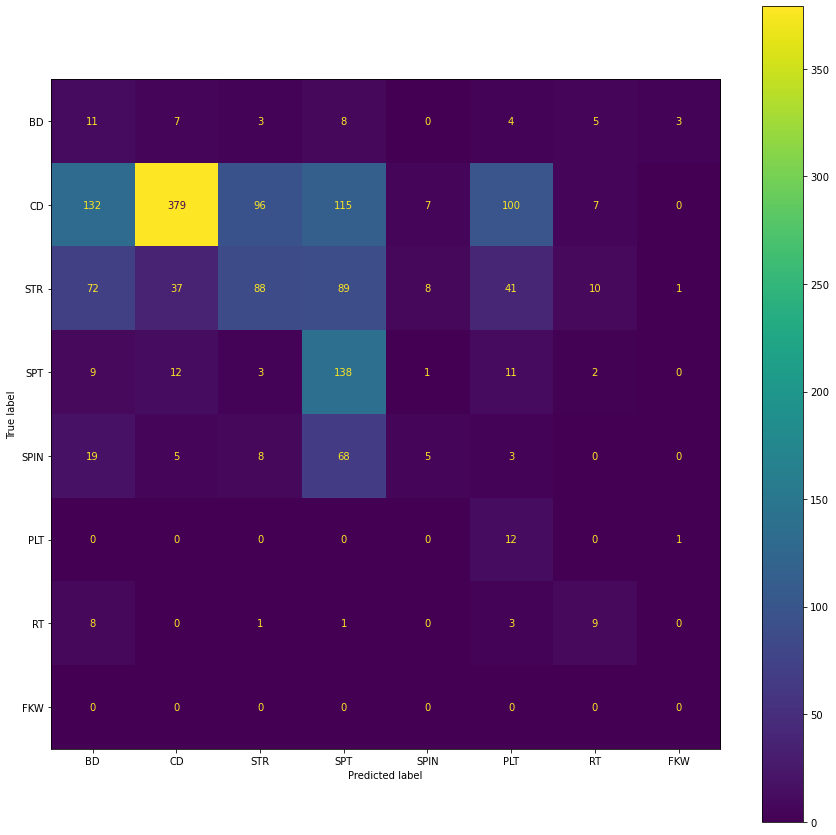

In [74]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


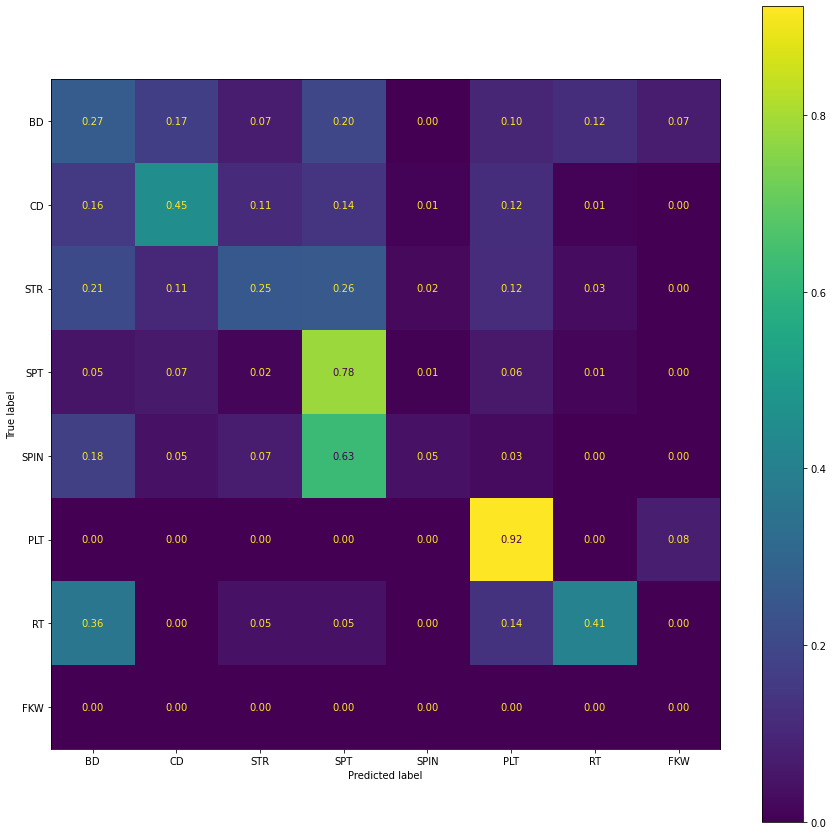

In [75]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## top k accuracy score

In [76]:
from sklearn.metrics import top_k_accuracy_score

In [77]:
top_k = []
for kk in range(1, num_species+1):
    print('k='+str(kk)+':  ')
    this_acc = top_k_accuracy_score(label_test, label_pred, k=kk, labels=list(range(num_species)))
    print(this_acc)
    top_k.append(this_acc)

k=1:  
0.4163424124513619
k=2:  
0.579118028534371
k=3:  
0.7036316472114138
k=4:  
0.7898832684824902
k=5:  
0.8651102464332037
k=6:  
0.9280155642023347
k=7:  
0.9734111543450065
k=8:  
1.0


/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1693: UndefinedMetricWarning: 'k' (8) greater than or equal to 'n_classes' (8) will result in a perfect score and is therefore meaningless.
  warnings.warn(


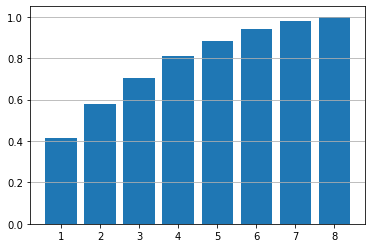

In [57]:
# %matplotlib inline
fig = plt.figure()
ax = fig.subplots()
ax.bar(list(range(1, num_species+1)), top_k)
ax.grid(axis='y')